In [1]:
# importing the requisite lbraries and setting some parameters
import pandas as pd
import json
import requests
import numpy as np
import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# set the Day_0 and Day_n and calculate the duration
day0 = "2020-02-01"
till_date = "2020-04-13"
tot_days = (date.today() - datetime.datetime.strptime(day0, "%Y-%m-%d").date()).days
print("Data available for " + str(tot_days) + " days.")

# setup the Figure rcParameters
SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 9
plt.rc("font", size = MEDIUM_SIZE)
plt.rc("axes", titlesize = SMALL_SIZE)
plt.rc("axes", labelsize = MEDIUM_SIZE)
plt.rc("xtick", labelsize = SMALL_SIZE)
plt.rc("ytick", labelsize = SMALL_SIZE)
plt.rc("legend", fontsize = SMALL_SIZE)
plt.rc("figure", titlesize = BIGGER_SIZE)

Data available for 72 days.


In [2]:
# read the API
api_data_raw = requests.get("https://api.covid19india.org/raw_data.json").json()
head = list(api_data_raw["raw_data"][0].keys())

In [3]:
# making an empty dataframe to which the data from the API is added
temp = pd.DataFrame()
for i in api_data_raw["raw_data"]:
    api_data = pd.DataFrame([i.values()], columns = head)
    temp = temp.append(api_data, ignore_index = True)

# remove empty data rows
temp1 = list(temp.loc[0: len(api_data_raw["raw_data"]), "currentstatus"])
non_empty_temp = [i for i, item in enumerate(temp1) if item != ""]
api_data_raw = temp[0: len(non_empty_temp)]

In [4]:
# total number of corona virus cases in India
print("There are a total of " + str(len(api_data_raw)) + " corona virus patients in India.")

There are a total of 9538 corona virus patients in India.


In [5]:
# finding the printing the nationalities of corona virus patients in India
unique_nationalities = set(api_data_raw["nationality"].values.tolist())
unique_nationalities = list(unique_nationalities)
unique_nationalities.remove('')
print(unique_nationalities)

['Myanmar', 'Malaysia', 'Phillipines', 'India', 'Italy', 'Canada', 'United States of America', 'Thailand', 'United Kingdom', 'Tibet', 'Indonesia']


In [6]:
# manipulating the API data to get the date column in the correct format
temp_data = api_data_raw.copy()
temp1 = list(api_data_raw["dateannounced"])
DATE = [datetime.datetime.strptime(x, "%d/%m/%Y") for x in temp1]
temp_data["dateannounced"] = DATE
temp2 = pd.to_datetime(temp_data.dateannounced, format = "%Y-%m-%d")
temp_data["dateannounced"] = temp2.dt.strftime("%Y-%m-%d")

# set till_date as the last date available in api_data_raw
yesterday = date.today() - timedelta(days = 1)
date_yesterday = yesterday.strftime("%Y-%m-%d")
date_yesterday = till_date
data_temp = temp_data[(temp_data["dateannounced"] <= date_yesterday)]

# Preparing the state and district wise DataFrames

In [7]:
# preparing the district data
data_district = data_temp.copy()
data_district = data_district.rename({"detecteddistrict": "District"}, axis = "columns")
data_district = data_district.rename({"dateannounced": "Date"}, axis = "columns")

data_district.loc[:, "Confirmed"] = np.ones((data_temp["dateannounced"].size), dtype = 'int')
data_district.loc[:, "Recovered"] = np.zeros((data_temp["dateannounced"].size), dtype = 'int')
data_district.loc[:, "Fatalities"] = np.zeros((data_temp["dateannounced"].size), dtype = "int")

temp = data_district[data_district["currentstatus"] == "Recovered"]
data_district.loc[list(temp.index), "Recovered"] = 1
temp = data_district[data_district["currentstatus"] == "Fatalities"]
data_district.loc[list(temp.index), "Fatalities"] = 1

temp_data = data_district.copy()
temp2 = pd.to_datetime(temp_data.Date, format = "%Y-%m-%d")
data_district.loc[:, "Date"] = temp2.dt.strftime("%Y-%m-%d")

districts = list(data_district.District.unique())
district_data = pd.DataFrame()

for j in range (0, len(districts)):
    st = data_district.query("District == " + '"' + districts[j] + '"')
    date = list(st.Date.unique())
    a = list(pd.date_range(start = day0, end = till_date).date)
    dat1 = dict()
    dat2 = dict()
    for i in a:
        dt = st["Date"] == str(i)
        aa = st.loc[dt].Confirmed.sum()
        bb = st.loc[dt].Fatalities.sum()
        dat1[i] = aa
        dat2[i] = bb
    datc = np.array(list(dat1.values())).cumsum()
    datf = np.array(list(dat2.values())).cumsum()
    nam = pd.Series([districts[j]])
    name = nam.repeat(len(a))
    days = np.arange(len(a))
    tempdata = {"District": name, "Date": pd.to_datetime(a, format = '%Y-%m-%d'), "Day": days, "ConfirmedCases": datc.T, "Fatalities": datf.T,}
    dd = pd.DataFrame.from_dict(tempdata)
    district_data = district_data.append(dd, ignore_index = True)

temp = pd.to_datetime(district_data.Date)
district_data["Date"] = temp.dt.strftime("%Y-%m-%d")

# removing those entries from the district database which don't have the district name
no_district_name = []
for ind, i in district_data.iterrows():
    if i["District"] == "":
        no_district_name.append(ind)
district_data = district_data.drop(no_district_name)

In [8]:
# preparing the state data
data = data_temp.copy()
data = data.rename({"detectedstate": "State"}, axis = "columns")
data = data.rename({"dateannounced": "Date"}, axis = "columns")

data.loc[:, "Confirmed"] = np.ones((data_temp["dateannounced"].size), dtype = "int")
data.loc[:, "Recovered"] = np.zeros((data_temp["dateannounced"].size), dtype = "int")
data.loc[:, "Fatalities"] = np.zeros((data_temp["dateannounced"].size), dtype = "int")

temp = data[data["currentstatus"] == "Recovered"]
data.loc[list(temp.index), "Recovered"] = 1
temp = data[data["currentstatus"] == "Fatalities"]
data.loc[list(temp.index), "Fatalities"] = 1

temp_data = data.copy()
temp2 = pd.to_datetime(temp_data.Date, format = "%Y-%m-%d")
data.loc[:, "Date"] = temp2.dt.strftime("%Y-%m-%d")

states = list(data.State.unique())
state_data = pd.DataFrame()

for j in range (0, len(states)):
    st = data.query("State == " +  '"' + states[j] + '"')
    date = list(st.Date.unique())
    a = list(pd.date_range(start = day0, end = till_date).date)
    dat1 = dict()
    dat2 = dict()
    for i in a:
        dt = st["Date"] == str(i)
        aa = st.loc[dt].Confirmed.sum()
        bb = st.loc[dt].Fatalities.sum()
        dat1[i] = aa
        dat2[i] = bb
    datc = np.array(list(dat1.values())).cumsum()
    datf = np.array(list(dat2.values())).cumsum()
    nam = pd.Series([states[j]])
    name = nam.repeat(len(a))
    days = np.arange(len(a))
    tempdata = {"State": name, "Date": pd.to_datetime(a, format = "%Y-%m-%d"), "Day": days, "ConfirmedCases": datc.T, "Fatalities": datf.T,}
    dd = pd.DataFrame.from_dict(tempdata)
    state_data = state_data.append(dd, ignore_index = True)

temp = pd.to_datetime(state_data.Date)
state_data["Date"] = temp.dt.strftime("%Y-%m-%d")

# removing those entries from the state database which don't have the state name
no_state_name = []
for ind, i in state_data.iterrows():
    if i["State"] == "":
        no_state_name.append(ind)
state_data = state_data.drop(no_state_name)

# State wise analysis

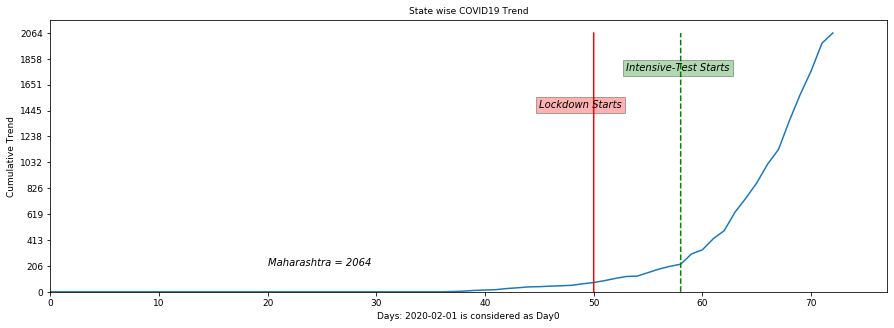

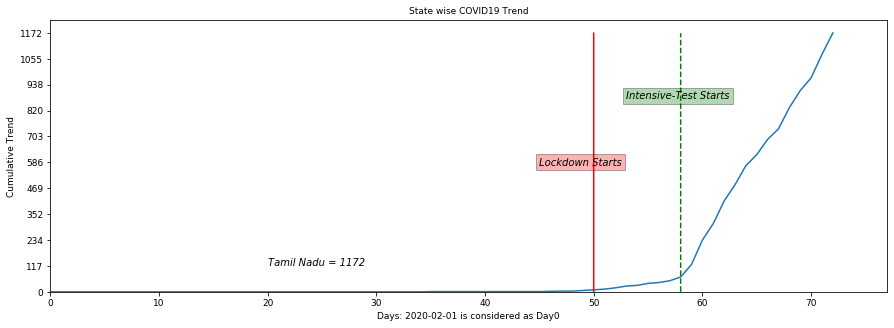

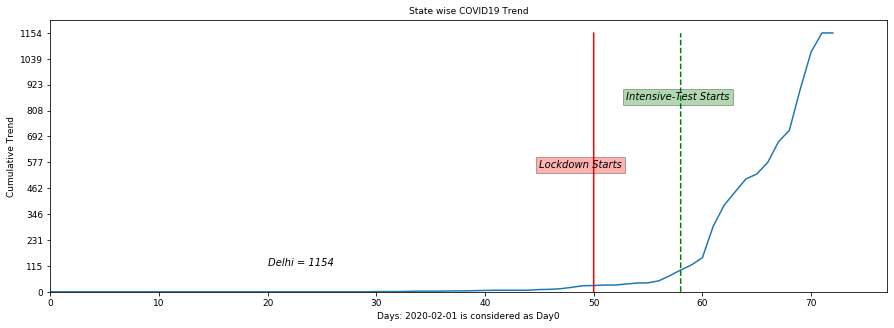

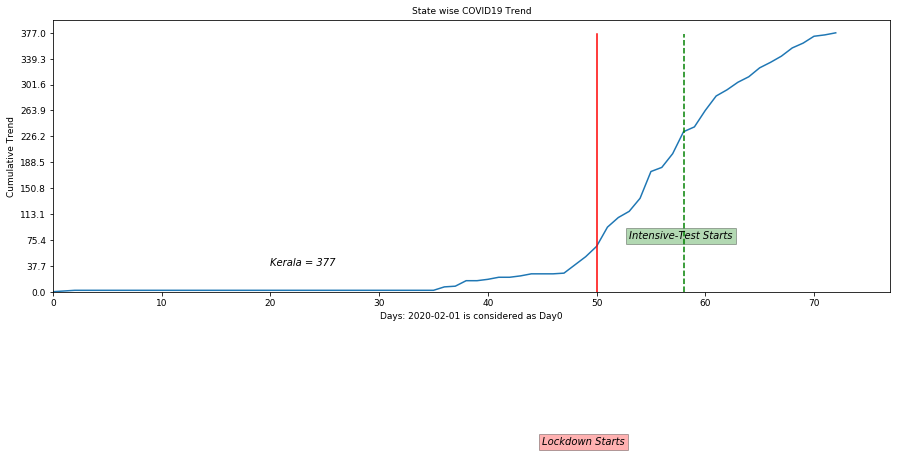

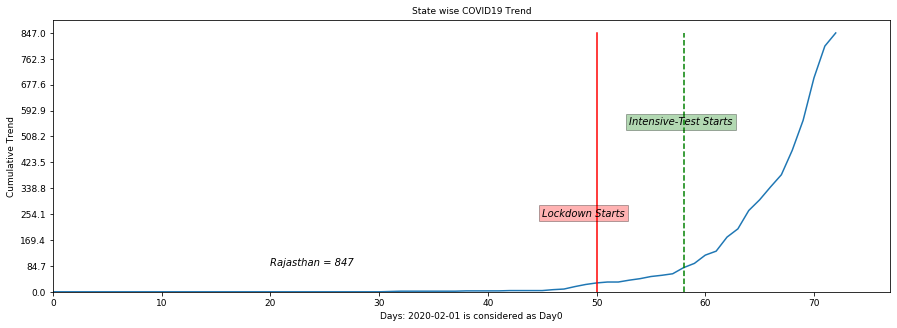

In [9]:
# plotting the infection data for the states with the most patients
no_states = 5
xloc = 20

train_state = state_data
states = list(train_state.State.unique())
gb = pd.DataFrame(train_state.groupby(["State"])["ConfirmedCases"].agg("sum"))
stsort = gb.sort_values(by = ["ConfirmedCases"], ascending = False)

for j in range (no_states):
    data_for_graph = train_state.query("State == " + '"' + stsort.index[j] + '"')
    tss = data_for_graph.ConfirmedCases
    days = (data_for_graph.Day)
    plt.figure(figsize = (15, 5))
    plt.plot(days, (tss))
    plt.xlabel("Days: " + str(day0) + " is considered as Day0")
    plt.ylabel("Cumulative Trend")
    plt.xticks(np.arange(0, tot_days + 5, 10))
    plt.xlim([0, tot_days + 5])
    plt.ylim(tss.iloc[-1] + 1)
    plt.yticks(np.arange(0, tss.iloc[-1] + 1, tss.iloc[-1] / 10))#, tss.iloc[-1] + 1, tss.iloc[-1] / 10)#100, tss.iloc[-1], 100
    plt.text(xloc, tss.iloc[-1] / 10, str(stsort.index[j]) + " = " + str(tss.iloc[-1]), style = "oblique")
    plt.title("State wise COVID19 Trend")
    
    rangey = np.arange(0, tss.iloc[-1])
    lockday = (datetime.datetime.strptime("2020-03-22", "%Y-%m-%d").date() - datetime.datetime.strptime(day0, "%Y-%m-%d").date()).days
    intense_day = (datetime.datetime.strptime("2020-03-30", "%Y-%m-%d").date() - datetime.datetime.strptime(day0, "%Y-%m-%d").date()).days
    plt.plot(np.ones((rangey.size)) * lockday,np.arange(0, tss.iloc[-1]), "r", label = "Lockdown_day")
    plt.text(lockday - 5, tss.iloc[-1] - 600, "Lockdown Starts", style = "italic", bbox = {"facecolor": "red", "alpha": 0.3, "pad": 3})
    plt.plot(np.ones((rangey.size)) * intense_day, np.arange(0, tss.iloc[-1]), "g--", label = "Intensive-Test Starts")
    plt.text(intense_day - 5, tss.iloc[-1] - 300, "Intensive-Test Starts", style = "italic", bbox = {"facecolor": "green", "alpha": 0.3, "pad": 3})
    plt.show()

# District wise analysis

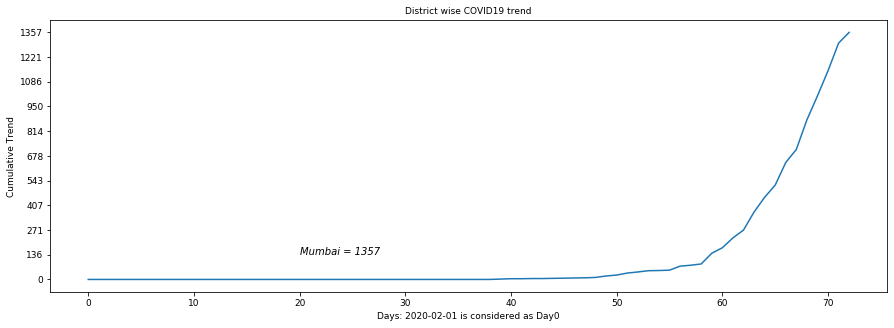

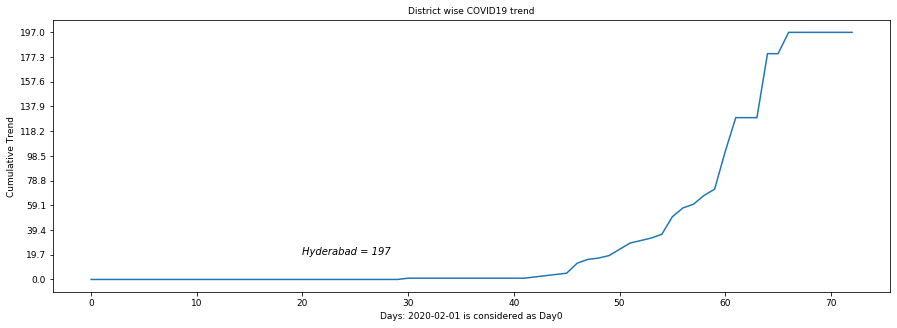

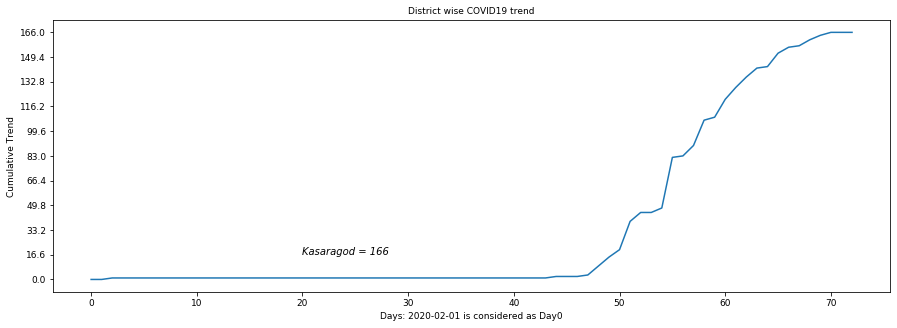

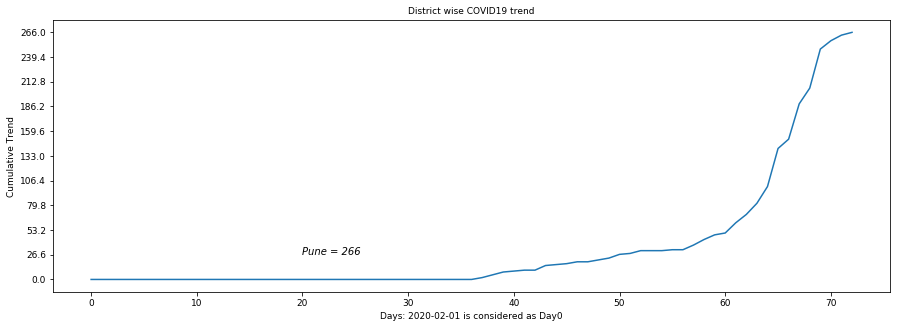

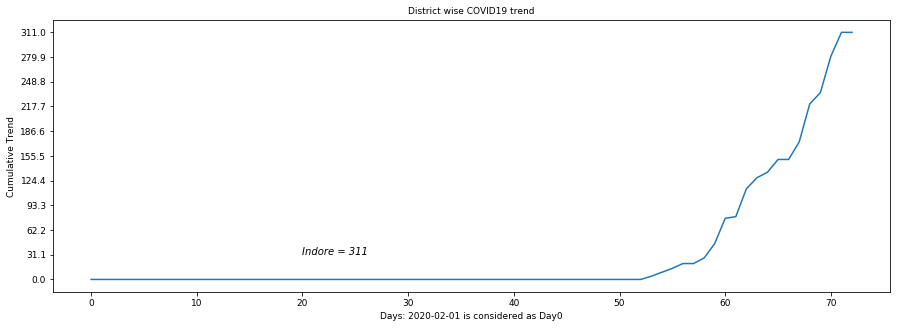

In [10]:
# plotting the infection data for the districts with the most patients
no_districts = 5

traind = district_data
districts = list(traind.District.unique())
gb = pd.DataFrame(traind.groupby(["District"])["ConfirmedCases"].agg("sum"))
stsort = gb.sort_values(by = ["ConfirmedCases"], ascending = False)

for j in range(no_districts):
    data_for_graph = traind.query("District == " + '"' + stsort.index[j] + '"')
    tss = data_for_graph.ConfirmedCases
    days = (data_for_graph.Day)
    plt.figure(figsize = (15, 5))
    plt.plot(days, (tss))
    plt.xlabel("Days: " + str(day0) + " is considered as Day0")
    plt.ylabel("Cumulative Trend")
    plt.xticks(np.arange(0, tot_days + 5, 10))
    plt.yticks(np.arange(0, tss.iloc[-1] + 1, tss.iloc[-1] / 10))
    plt.text(20,  tss.iloc[-1] / 10, str(stsort.index[j]) + " = " + str(tss.iloc[-1]), style = "oblique")
    plt.title("District wise COVID19 trend")

# Type of transmission

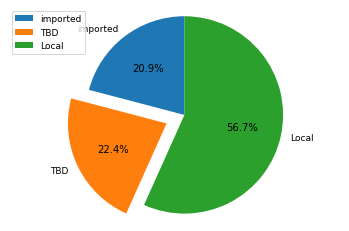

In [11]:
# plotting the overall type of transmission
query = data_temp.query("typeoftransmission == \"Imported\"")
imported = query.loc[:, "typeoftransmission"].count()
query = data_temp.query("typeoftransmission == \"TBD\"")
tbd = query.loc[:, "typeoftransmission"].count()
query = data_temp.query("typeoftransmission == \"Local\"")
local = query.loc[:, "typeoftransmission"].count()
data_for_pie_chart = np.array([imported, tbd, local])
fig1, ax1 = plt.subplots()
ax1.pie(data_for_pie_chart, explode = (0, 0.2, 0), labels = ("imported", "TBD", "Local"), autopct = "%1.1f%%", startangle = 90)
ax1.axis("equal")
plt.legend()
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


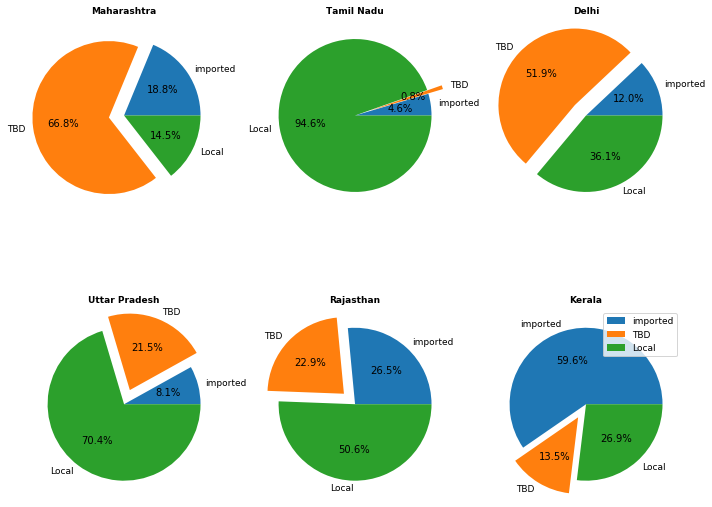

In [12]:
# plotting the type of transmission for some specific states
state = list(["Maharashtra", "Tamil Nadu", "Delhi", "Uttar Pradesh", "Rajasthan", "Kerala"])
count = 0

fig1, ax1 = plt.subplots(2,3, figsize = (10, 12), sharey = True)
for i in range(0, 2):
    for j in range(0, int(len(state) / 2), 1):
        detected_state = data_temp.query("detectedstate == \"" + str(state[count]) + "\"")
        query = detected_state.query("typeoftransmission == \"Imported\"")
        imported = query.loc[:, "typeoftransmission"].count()
        query = detected_state.query("typeoftransmission == \"TBD\"")
        tbd = query.loc[:, "typeoftransmission"].count()
        query = detected_state.query("typeoftransmission == \"Local\"")
        local = query.loc[:, "typeoftransmission"].count()        
        data_for_pie_chart = np.array([imported, tbd, local])
        patches, texts, autotexts = ax1[i,j].pie(data_for_pie_chart, explode = (0, 0.2, 0), labels = ("imported", "TBD", "Local"), autopct = "%1.1f%%")
        ax1[i,j].set_title(str(state[count]), fontweight = "bold")
        plt.tight_layout()
        plt.legend()
        count += 1

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


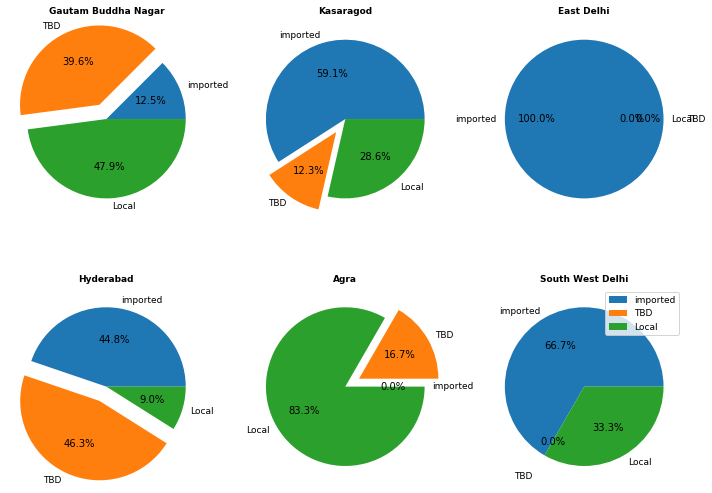

In [13]:
# plotting the type of transmission for some specific districts
district = list(["Gautam Buddha Nagar", "Kasaragod", "East Delhi", "Hyderabad", "Agra", "South West Delhi"])
count = 0

fig1, ax1 = plt.subplots(2, 3, figsize = (10, 10), sharey = True)
for i in range(0, 2):
    for j in range(0, int(len(district) / 2), 1):
        detected_district = data_temp.query("detecteddistrict == \"" + str(district[count]) + "\"")
        query = detected_district.query("typeoftransmission == \"Imported\"")
        imported = query.loc[:, "typeoftransmission"].count()
        query = detected_district.query("typeoftransmission == \"TBD\"")
        tbd = query.loc[:, "typeoftransmission"].count()
        query = detected_district.query("typeoftransmission == \"Local\"")
        local = query.loc[:, "typeoftransmission"].count()
        data_for_pie_chart = np.array([imported, tbd, local])
        patches, texts, autotexts = ax1[i,j].pie(data_for_pie_chart, explode = (0, 0.2, 0), labels = ("imported", "TBD", "Local"), autopct = "%1.1f%%")
        ax1[i, j].set_title(str(district[count]), fontweight = "bold")
        plt.tight_layout()
        plt.legend()
        count += 1